In [1]:
import os
import copy
import keras
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
from random import sample
from random import seed
from sklearn.metrics import roc_auc_score

In [2]:
# fix error with truncated image files
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
test_df = pd.read_csv('/home/jupyter-chima/data/correa/test_censored_bmi.csv')

In [4]:
test_df = test_df[test_df.Race.isin(['ASIAN','BLACK/AFRICAN AMERICAN','WHITE'])]

In [5]:
test_df.hiti_path = test_df.hiti_path.astype(str)

In [6]:
test_df = test_df[~test_df.hiti_path.str.contains('406e0996e5f1cf082487d7d096574d10b46c0c52710222a4884db1cc|dd97e997cc2a4166dc6e192cb62e29553aa28f4671d98c9577e32cfd|6224290209c45bb2b3e07b3b3a27778d1d10f7953567b3c59158e099')]

In [7]:
test_df['bmi_cat'].isnull().sum() # number of bmi entried that do not have a value

5669

In [8]:
test_df = test_df[test_df['bmi_cat'].notna()] # drop rows without a bmi category

In [9]:
test_df['bmi_cat'].isna().sum() == 0

True

In [10]:
test_df = test_df[~test_df.bmi_cat.str.contains('UNKNOWN')] # remove the entry where BMI is unknown

In [11]:
test_df.bmi_cat.value_counts()

obese          2326
overweight     1906
normal         1675
underweight     255
Name: bmi_cat, dtype: int64

In [12]:
test_df.Race.value_counts()

BLACK/AFRICAN AMERICAN    3061
WHITE                     2865
ASIAN                      236
Name: Race, dtype: int64

In [13]:
IMAGE_WIDTH, IMAGE_HEIGHT = (224, 224)
EPOCHS = 20
BATCH_SIZE = 256
learning_rate = 1e-3
decay_val= 0.0 
image_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

In [14]:
validate_gen = ImageDataGenerator()

In [15]:
# see the class names
class_names = test_df.Race.value_counts().index.tolist()
class_names.sort()
class_names

['ASIAN', 'BLACK/AFRICAN AMERICAN', 'WHITE']

In [16]:
model = keras.models.load_model('/home/jupyter-chima/Bias/Emory_CXR/Three_classes/EfficientNet/Emory_CXR_three_classes_EfficientNet.h5')

In [17]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_logits (Dense)         (None, 3)                 3843      
_________________________________________________________________
predictions (Activation)     (None, 3)                 0         
Total params: 4,053,414
Trainable params: 4,011,391
Non-trainable params: 42,023
_________________________________________________________________


In [18]:
test_batches=validate_gen.flow_from_dataframe(
    test_df,
    x_col="hiti_path", 
    y_col="Race", 
    class_mode="categorical",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=False,
    batch_size=BATCH_SIZE, 
    dtype='float32'
)

Found 6162 validated image filenames belonging to 3 classes.


In [19]:
predictions = model.predict(test_batches, len(test_batches.filenames)) 

In [20]:
y_hat = np.argmax(predictions, axis=1)
y_hat = list(y_hat)

In [21]:
# building the confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
matrix = confusion_matrix(test_batches.classes, y_hat)
print(matrix)
print('Classification Report')
# batches are made in alphabetical order if shuffle is false
print(classification_report(test_batches.classes, y_hat, target_names=class_names,  zero_division = 0)) 

Confusion Matrix
[[  98   14  124]
 [  25 2833  203]
 [  30   57 2778]]
Classification Report
                        precision    recall  f1-score   support

                 ASIAN       0.64      0.42      0.50       236
BLACK/AFRICAN AMERICAN       0.98      0.93      0.95      3061
                 WHITE       0.89      0.97      0.93      2865

              accuracy                           0.93      6162
             macro avg       0.84      0.77      0.79      6162
          weighted avg       0.93      0.93      0.92      6162



[Text(0.5, 0, 'ASIAN'),
 Text(1.5, 0, 'BLACK/AFRICAN AMERICAN'),
 Text(2.5, 0, 'WHITE')]

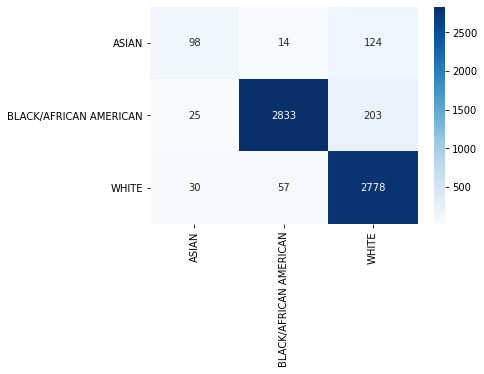

In [22]:
heatmap = sns.heatmap(matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names);
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0) 
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

In [23]:
from keras.utils.np_utils import to_categorical   

y_actual_categorical = to_categorical(test_batches.classes, num_classes=3)

In [24]:
# compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_actual_categorical[:, i], predictions[:, i])
    roc_auc[class_names[i]] = auc(fpr[i], tpr[i])

In [25]:
roc_auc

{'ASIAN': 0.9442767293798658,
 'BLACK/AFRICAN AMERICAN': 0.9878595611684211,
 'WHITE': 0.9815127295902298}

In [26]:
# add the predictions to the data_frame
test_df["Model predictions"] = y_hat
test_df["Actual predictions"]= test_batches.classes

In [27]:
bmi_categories = test_df.bmi_cat.value_counts().index.tolist()
bmi_categories

['obese', 'overweight', 'normal', 'underweight']

In [28]:
one = test_df[test_df["bmi_cat"] == "obese"]
two = test_df[test_df["bmi_cat"] == "overweight"]
three = test_df[test_df["bmi_cat"] == "normal"]
four = test_df[test_df["bmi_cat"] == "underweight"]
subgroups = [one, two, three, four]

In [29]:
# generates classification reports for each bmi category
counter = 0
for group in subgroups:
    # print('Confusion Matrix:'+ bmi_categories[counter])
    # print(confusion_matrix(group["Actual predictions"], group["Model predictions"]))
    print('Classification Report: ' + bmi_categories[counter])
    print(classification_report(group["Actual predictions"], group["Model predictions"], target_names=class_names))
    counter+=1

Classification Report: obese
                        precision    recall  f1-score   support

                 ASIAN       0.33      0.21      0.26        28
BLACK/AFRICAN AMERICAN       0.98      0.94      0.96      1347
                 WHITE       0.91      0.98      0.94       951

              accuracy                           0.95      2326
             macro avg       0.74      0.71      0.72      2326
          weighted avg       0.95      0.95      0.95      2326

Classification Report: overweight
                        precision    recall  f1-score   support

                 ASIAN       0.65      0.41      0.50        83
BLACK/AFRICAN AMERICAN       0.97      0.93      0.95       896
                 WHITE       0.90      0.97      0.93       927

              accuracy                           0.92      1906
             macro avg       0.84      0.77      0.79      1906
          weighted avg       0.92      0.92      0.92      1906

Classification Report: normal
     

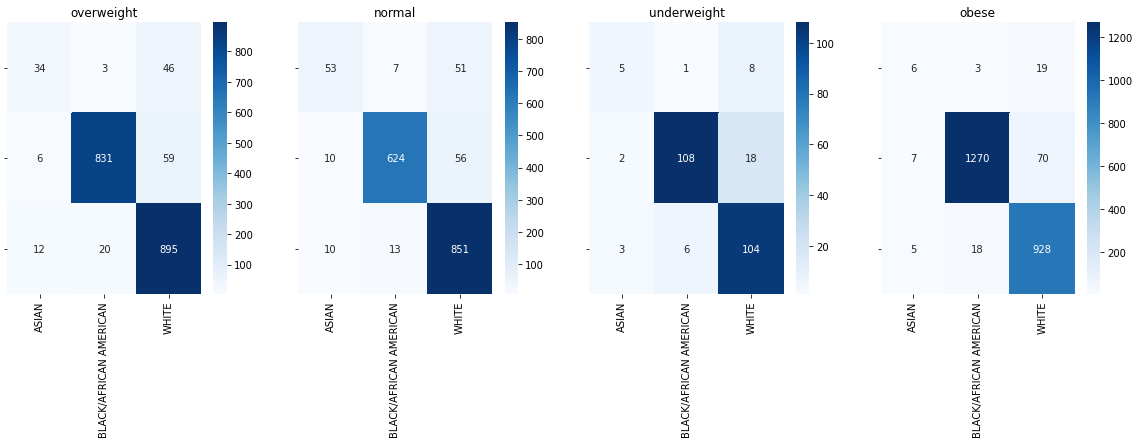

In [30]:
counter = 0

f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')
for group in subgroups:
    cm = confusion_matrix(group["Actual predictions"], group["Model predictions"])
    heatmap = sns.heatmap(cm, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, ax=axes[counter-1]);
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0) 
    heatmap.set_title(bmi_categories[counter])
    counter+=1

In [31]:
# get model predictions for the group
group_one_batches=validate_gen.flow_from_dataframe(
    one,
    x_col="hiti_path", 
    y_col="Race", 
    class_mode="categorical",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=False,
    batch_size=BATCH_SIZE, 
    dtype='float32'
)

Found 2326 validated image filenames belonging to 3 classes.


In [32]:
group_one_predictions = model.predict(group_one_batches, len(group_one_batches.filenames)) 

In [33]:
# calculate the auc for the group
group_one_actual_category = to_categorical(group_one_batches.classes, num_classes=3)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(group_one_actual_category[:, i], group_one_predictions[:, i])
    roc_auc[class_names[i]] = auc(fpr[i], tpr[i])
    
print(roc_auc)

{'ASIAN': 0.9257584234738282, 'BLACK/AFRICAN AMERICAN': 0.9903534734244678, 'WHITE': 0.9879093776885575}


In [34]:
# get model predictions for the group
group_two_batches=validate_gen.flow_from_dataframe(
    two,
    x_col="hiti_path", 
    y_col="Race", 
    class_mode="categorical",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=False,
    batch_size=BATCH_SIZE, 
    dtype='float32'
)

Found 1906 validated image filenames belonging to 3 classes.


In [35]:
group_two_predictions = model.predict(group_two_batches, len(group_two_batches.filenames))

In [36]:
# calculate the auc for the group
group_two_actual_category = to_categorical(group_two_batches.classes, num_classes=3)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(group_two_actual_category[:, i], group_two_predictions[:, i])
    roc_auc[class_names[i]] = auc(fpr[i], tpr[i])
    
print(roc_auc)

{'ASIAN': 0.963881857655526, 'BLACK/AFRICAN AMERICAN': 0.9873850777934936, 'WHITE': 0.9802425917294468}


In [37]:
# get model predictions for the group
group_three_batches=validate_gen.flow_from_dataframe(
    three,
    x_col="hiti_path", 
    y_col="Race", 
    class_mode="categorical",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=False,
    batch_size=BATCH_SIZE, 
    dtype='float32'
)

Found 1675 validated image filenames belonging to 3 classes.


In [38]:
group_three_predictions = model.predict(group_three_batches, len(group_three_batches.filenames))

In [39]:
# calculate the auc for the group
group_three_actual_category = to_categorical(group_three_batches.classes, num_classes=3)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(group_three_actual_category[:, i], group_three_predictions[:, i])
    roc_auc[class_names[i]] = auc(fpr[i], tpr[i])
    
print(roc_auc)

{'ASIAN': 0.935692725974056, 'BLACK/AFRICAN AMERICAN': 0.9855866990362686, 'WHITE': 0.9762353694038058}


In [40]:
# get model predictions for the group
group_four_batches=validate_gen.flow_from_dataframe(
    four,
    x_col="hiti_path", 
    y_col="Race", 
    class_mode="categorical",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=False,
    batch_size=BATCH_SIZE, 
    dtype='float32'
)

Found 255 validated image filenames belonging to 3 classes.


In [41]:
group_four_predictions = model.predict(group_four_batches, len(group_four_batches.filenames))

In [42]:
# calculate the auc for the group
group_four_actual_category = to_categorical(group_four_batches.classes, num_classes=3)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(group_four_actual_category[:, i], group_four_predictions[:, i])
    roc_auc[class_names[i]] = auc(fpr[i], tpr[i])
    
print(roc_auc)

{'ASIAN': 0.8609958506224067, 'BLACK/AFRICAN AMERICAN': 0.9746555118110236, 'WHITE': 0.9588682537704101}
